# Proyecto PES - Separador de voz 

La idea principal del proyecto, es separar y quitar la voz de un archivo de audio o canción, que posea varios instrumentos y una voz cantada

**Para este entorno de testeo se utilizara la libreria librosa**


In [24]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

import librosa

import librosa.display

### Load my example example with vocals
  
__librosa.load():__
* Load an audio file as a floating point time series.
* Audio will be automatically resampled to the given rate (default sr=22050).
* To preserve the native sampling rate of the file, use sr=None.

In [25]:
# El archivo utilizado debe estar en un codec soportado por `soundfile`(WAV, FLAC, OGG and MAT) or `audioread` 
my_song = "./sample_audio/Beatles_ComeTogether.wav"
# Cargo 10 segundos de la cancion para procesar (duration = 10*60)
y, sr = librosa.load(my_song, sr=None, duration=600)
# And compute the spectrogram magnitude and phase
S_full, phase = librosa.magphase(librosa.stft(y))

# Play back a 5-second excerpt with vocals
# Audio(data=y[10*sr:20*sr], rate=sr)

### 10 seconds example audio audio loaded

In [26]:
Audio(data=y[10*sr:20*sr], rate=sr)

### Plot a 10-second slice of the spectrum


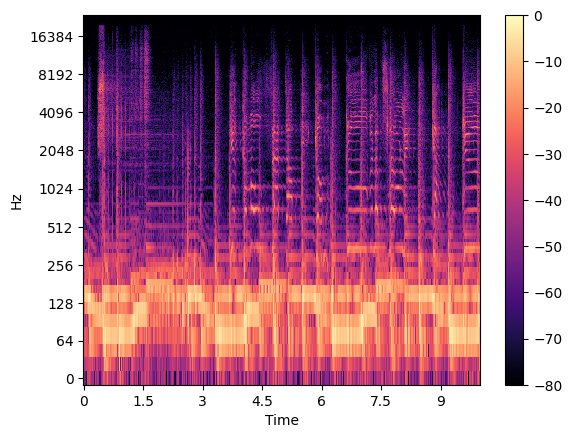

In [22]:
idx = slice(*librosa.time_to_frames([10, 20], sr=sr))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax)

The wiggly lines above are due to the vocal component.
Our goal is to separate them from the accompanying
instrumentation.

In [23]:
# We'll compare frames using cosine similarity, and aggregate similar frames
# by taking their (per-frequency) median value.
#
# To avoid being biased by local continuity, we constrain similar frames to be
# separated by at least 2 seconds.
#
# This suppresses sparse/non-repetetitive deviations from the average spectrum,
# and works well to discard vocal elements.

S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))

# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimum
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)

The raw filter output can be used as a mask,
but it sounds better if we use soft-masking.



In [12]:
# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground = mask_v * S_full
S_background = mask_i * S_full

Plot the same slice, but separated into its foreground and background



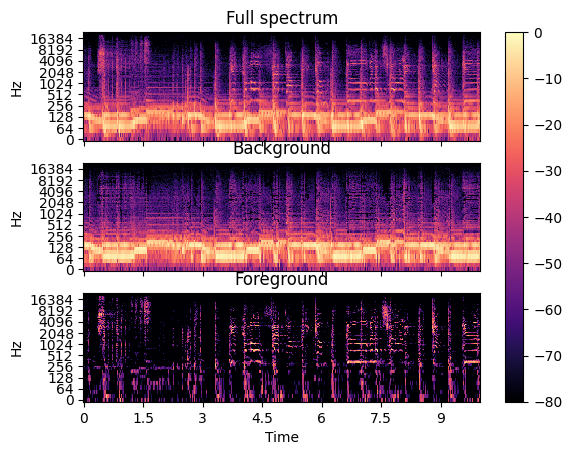

In [13]:
# sphinx_gallery_thumbnail_number = 2

fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
img = librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[0])
ax[0].set(title='Full spectrum')
ax[0].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(S_background[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[1])
ax[1].set(title='Background')
ax[1].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[2])
ax[2].set(title='Foreground')
fig.colorbar(img, ax=ax)

Recover the foreground audio from the masked spectrogram.
To do this, we'll need to re-introduce the phase information
that we had previously set aside.



In [14]:
y_foreground = librosa.istft(S_foreground * phase)

# Play back a 5-second excerpt with vocals
Audio(data=y_foreground[10*sr:20*sr], rate=sr)

In [15]:
y_backgroud = librosa.istft(S_background* phase)

# Play back a 5-second excerpt with vocals
Audio(data=y_backgroud[10*sr:20*sr], rate=sr)

### Load librosa example

In [27]:
y_librosa, sr_librosa = librosa.load(librosa.ex('fishin'), duration=120)
S_full_librosa_ex, phase_librosa_ex = librosa.magphase(librosa.stft(y_librosa))

In [28]:
Audio(data=y_librosa[10*sr_librosa:15*sr_librosa], rate=sr_librosa)

### Do the same with the Librosa music example

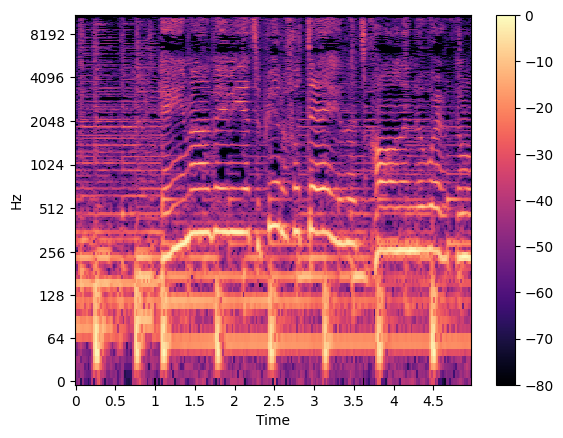

In [29]:
idx = slice(*librosa.time_to_frames([10, 15], sr=sr_librosa))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S_full_librosa_ex[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr_librosa, ax=ax)
fig.colorbar(img, ax=ax)

In [30]:
S_filter_librosa_ex = librosa.decompose.nn_filter(S_full_librosa_ex,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr_librosa)))

S_filter_librosa_ex = np.minimum(S_full_librosa_ex, S_filter_librosa_ex)

In [31]:
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter_librosa_ex,
                               margin_i * (S_full_librosa_ex - S_filter_librosa_ex),
                               power=power)

mask_v = librosa.util.softmask(S_full_librosa_ex - S_filter_librosa_ex,
                               margin_v * S_filter_librosa_ex,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground_librosa_ex = mask_v * S_full_librosa_ex
S_background_librosa_ex = mask_i * S_full_librosa_ex

In [32]:
y_librosa_foreground = librosa.istft(S_foreground_librosa_ex * phase_librosa_ex)
# Play back a 5-second excerpt with vocals
Audio(data=y_librosa_foreground[10*sr_librosa:15*sr_librosa], rate=sr_librosa)